https://youtu.be/83tnWs_YBRQ

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# # # Install the required libraries
# # #SAM
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# # #Transformers
# !pip install -q git+https://github.com/huggingface/transformers.git
# # #Datasets to prepare data and monai if you want to use special loss functions
# !pip install datasets


In [3]:
# !pip uninstall -y numpy



In [4]:
# !pip install numpy==2.0.2

# !pip install albumentations

In [5]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image
from tqdm import tqdm
from statistics import mean

from transformers import SamProcessor
from transformers import SamModel

from datasets import Dataset
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torch.nn.functional import threshold, normalize
import torch.nn.functional as F
from torch.optim import Adam

import albumentations as A
import cv2



In [6]:
# ===== Datasets for train =======

paleo_images_dir = '/content/drive/MyDrive/IT-geo/padded_1024/train/images'
paleo_masks_dir = '/content/drive/MyDrive/IT-geo/padded_1024/train/masks'
rivers_images_dir = '/content/drive/MyDrive/IT-geo/real_river/img_npy'
rivers_masks_dir = '/content/drive/MyDrive/IT-geo/real_river/masks_npy'

paleo_img_files = sorted([f for f in os.listdir(paleo_images_dir) if f.endswith(".npy")])
paleo_mask_files = sorted([f for f in os.listdir(paleo_masks_dir) if f.endswith(".npy")])

rivers_img_files = sorted([f for f in os.listdir(rivers_images_dir) if f.endswith(".npy")])
rivers_mask_files = sorted([f for f in os.listdir(rivers_masks_dir) if f.endswith(".npy")])

dataset_target_paleo = {
    "image": [np.load(os.path.join(paleo_images_dir, f)) for f in paleo_img_files],
    "label": [np.load(os.path.join(paleo_masks_dir, f)) for f in paleo_mask_files]
}

dataset_source_rivers = {
    "image": [np.load(os.path.join(rivers_images_dir, f)) for f in rivers_img_files],
    "label": [np.load(os.path.join(rivers_masks_dir, f)) for f in rivers_mask_files]
}

# ===== Datasets for validation =======

images_val_dir = '/content/drive/MyDrive/IT-geo/padded_1024/val/images'
masks_val_dir = '/content/drive/MyDrive/IT-geo/padded_1024/val/masks'

val_img_files = sorted([f for f in os.listdir(images_val_dir) if f.endswith(".npy")])
val_mask_files = sorted([f for f in os.listdir(masks_val_dir) if f.endswith(".npy")])

dataset_val = {
    "image": [np.load(os.path.join(images_val_dir, f)) for f in val_img_files],
    "label": [np.load(os.path.join(masks_val_dir, f)) for f in val_mask_files],
}

# ====== Check datasets =======

print(f"Source (Rivers): {len(dataset_source_rivers['image'])}")
print(f"Target (Paleo): {len(dataset_target_paleo['image'])}")
print(f"Val (Paleo): {len(dataset_val['image'])}")


Source (Rivers): 552
Target (Paleo): 32
Val (Paleo): 5


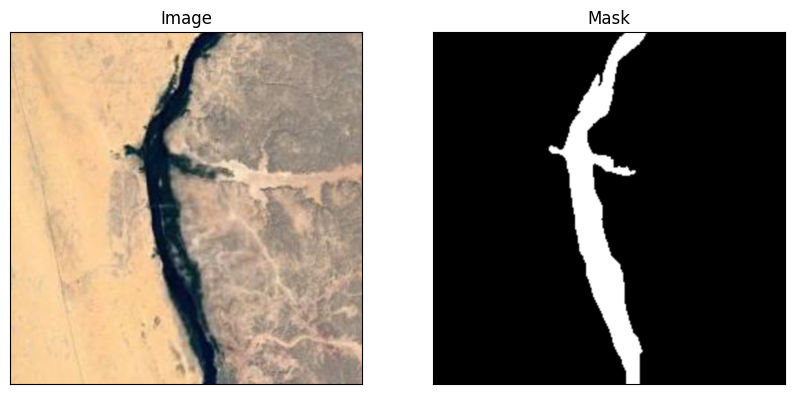

In [7]:
img_num = random.randint(0, len(paleo_img_files) - 1)
example_image = dataset_source_rivers["image"][img_num]
example_mask = dataset_source_rivers["label"][img_num]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [8]:
def get_random_points(ground_truth_map, n):
    y_indices, x_indices = np.where(ground_truth_map > 0)
    height, width = ground_truth_map.shape # Get height and width here

    if len(x_indices) == 0 or len(y_indices) == 0:
        # If no foreground pixels, return the center of the image
        return [[width // 2, height // 2], [width // 2, height // 2], [width // 2, height // 2]]

    # n_points = min(n, len(x_indices))
    random_indices = np.random.choice(len(x_indices), size=n, replace=False)
    final_points = []
    angles_deg = np.arange(0, 180, 30)
    angles_rad = np.radians(angles_deg)

    dirs = list(zip(np.sin(angles_rad), np.cos(angles_rad)))

    for idx in random_indices:
        start_x = x_indices[idx]
        start_y = y_indices[idx]
        min_len = float('inf')
        best_segment = None

        for dy, dx in dirs:
            dist_pos = 0
            cur_x, cur_y = start_x, start_y

            while True:
                next_x = cur_x + dx
                next_y = cur_y + dy
                ix, iy = int(round(next_x)), int(round(next_y))
                if 0 <= ix < width and 0 <= iy < height and ground_truth_map[iy, ix] > 0:
                    cur_x, cur_y = next_x, next_y
                    dist_pos += 1
                else:
                    break
            dist_neg = 0
            cur_x, cur_y = start_x, start_y

            while True:
                next_x = cur_x - dx
                next_y = cur_y - dy
                ix, iy = int(round(next_x)), int(round(next_y))
                if 0 <= ix < width and 0 <= iy < height and ground_truth_map[iy, ix] > 0:
                    cur_x, cur_y = next_x, next_y
                    dist_neg += 1
                else:
                    break
            total_len = dist_pos + dist_neg

            if total_len < min_len:
                min_len = total_len
                p1 = (start_y + dy * dist_pos, start_x + dx * dist_pos)
                p2 = (start_y - dy * dist_neg, start_x - dx * dist_neg)
                best_segment = (p1, p2)

        if best_segment is not None and min_len > 0:
            (y1, x1), (y2, x2) = best_segment
            mid_y = (y1 + y2) / 2
            mid_x = (x1 + x2) / 2
            sigma = min_len / 4.0

            if sigma == 0:
                final_points.append([int(start_x), int(start_y)])
                continue

            offset = np.random.normal(0, sigma)
            vec_y = y1 - y2
            vec_x = x1 - x2
            new_y = mid_y + (vec_y / min_len) * offset
            new_x = mid_x + (vec_x / min_len) * offset
            res_x = int(round(new_x))
            res_y = int(round(new_y))
            final_points.append([res_x, res_y])
        else:
            final_points.append([start_x, start_y])

    return final_points

In [9]:
def fade(t):
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def lerp(a, b, t):
    return a + t * (b - a)

def gradient(h, x, y):
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:, :, 0] * x + g[:, :, 1] * y

def perlin(x, y, seed=None):
    if seed is not None:
        np.random.seed(seed)
    else:
        np.random.seed(np.random.randint(0, 100000))

    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()

    xi = x.astype(int)
    yi = y.astype(int)
    xf = x - xi
    yf = y - yi

    u = fade(xf)
    v = fade(yf)

    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)

    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)
    return lerp(x1, x2, v)

class PerlinNoise(A.ImageOnlyTransform):
    def __init__(self, scale_range=(5, 20), alpha_range=(0.02, 0.1), always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.scale_range = scale_range
        self.alpha_range = alpha_range

    def apply(self, image, **params):
        scale = np.random.uniform(*self.scale_range)
        alpha = np.random.uniform(*self.alpha_range)
        h, w, c = image.shape
        noise = np.zeros((h, w, c))
        for i in range(c):
            xx = np.linspace(0, scale, w)
            yy = np.linspace(0, scale, h)
            x, y = np.meshgrid(xx, yy)
            noise[:, :, i] = perlin(x, y)
        image = image + noise * alpha
        image = np.clip(image, 0, 1)
        return image

class SAMDataset(Dataset):
    """
    This class is used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor, mode='train'):
        self.dataset = dataset
        self.processor = processor

        mode = 'train'
        if mode == 'train':
          self.transform = A.Compose([
              A.HorizontalFlip(p=0.5),
              A.VerticalFlip(p=0.5),
              A.RandomRotate90(p=0.5),
              A.Rotate(
                  limit=(0, 360),            # диапазон случайного угла
                  border_mode=cv2.BORDER_CONSTANT,  # константная заливка
                  fill=(255, 255, 255),                  # белый цвет для пустых областей
                  fill_mask=0,               # черный цвет для маски
                  p=0.5
              ),
              A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.1, p=0.4),
              # A.GaussNoise(var_limit=(0.0016, 0.04), mean=0, per_channel=True, p=0.3),
              # PerlinNoise(scale_range=(5, 20), alpha_range=(0.02, 0.1), p=0.3),
              # A.GaussianBlur(blur_limit=(3, 7), p=0.2),
          ])
        else:
          self.transform = A.Compose([])

    def __len__(self):
        return len(self.dataset["image"])

    def __getitem__(self, idx):
        image = self.dataset["image"][idx].copy()
        ground_truth_mask = self.dataset["label"][idx].copy()

        # Приведение к стандартному виду (H, W, C) или (H, W)
        if image.ndim == 3 and image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))

        if ground_truth_mask.ndim == 3 and ground_truth_mask.shape[0] == 1:
            ground_truth_mask = ground_truth_mask.squeeze(0)

        image = image.astype(np.float32)
        if np.max(image) > 1.0:
            image /= 255.0



        ground_truth_mask = (ground_truth_mask > 0).astype(np.float32)

        augmented = self.transform(image=image, mask=ground_truth_mask)
        image_np = augmented['image']  # (H, W, 3), [0, 1]
        mask_np = augmented['mask']    # (H, W)

        prompt = get_random_points(mask_np, 3)

        image_pil = Image.fromarray(np.clip(image_np * 255, 0, 255).astype(np.uint8))

        inputs = self.processor(image_pil, input_points=[[prompt]], return_tensors="pt", size={"longest_edge": 1024})
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        ground_truth_mask_tensor = torch.tensor(mask_np).unsqueeze(0)  # [1, H, W]
        H, W = inputs["pixel_values"].shape[1:]
        ground_truth_mask_tensor = TF.resize(
            ground_truth_mask_tensor,
            size=(H, W),
            interpolation=TF.InterpolationMode.NEAREST
        ).squeeze(0)
        inputs["ground_truth_mask"] = ground_truth_mask_tensor

        return inputs

In [10]:
def visualize_sam_example(example, image_idx=0):
    """
    Визуализирует изображение с точками промпта и маской
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    pixel_values = example["pixel_values"]  # [3, 1024, 1024]
    input_points = example["input_points"]  # [1, 3, 2]
    ground_truth_mask = example["ground_truth_mask"]  # [1, 512, 512]

    image = pixel_values.permute(1, 2, 0).cpu().numpy()  # [1024, 1024, 3]
    image = (image - image.min()) / (image.max() - image.min())

    # Выводим шейпы в заголовке
    image_shape = image.shape
    axes[0].imshow(image)

    points = input_points.squeeze(0).cpu().numpy()  # [3, 2]
    for i, (x, y) in enumerate(points):
        axes[0].scatter(x, y, c='red', s=50, marker='o', edgecolors='white', linewidths=1)
        axes[0].text(x, y, str(i+1), color='white', fontsize=12,
                    ha='center', va='center', fontweight='bold')
    axes[0].set_title(f"Image with {len(points)} points\nShape: {image_shape}")
    axes[0].axis('off')

    mask = ground_truth_mask.squeeze(0).cpu().numpy()  # [512, 512] вместо [1, 512, 512]
    mask_shape = mask.shape
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title(f"Ground Truth Mask\nShape: {mask_shape}")
    axes[1].axis('off')

    plt.suptitle(f"SAM Dataset Example {image_idx}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [27]:
def coral_loss(source, target):
    """
    Вычисляет CORAL loss между source и target feature maps.
    Вход: (Batch, Channels, H, W) - эмбеддинги SAM (B, 256, 64, 64)
    Мы хотим выровнять распределение признаков (Channels).
    """
    d = source.size(1)  # 256 channels

    # Flatten spatial dimensions: (B, C, H, W) -> (B * H * W, C)
    # Мы рассматриваем каждый "пиксель" фиче-карты как отдельный сэмпл данных.
    # Это помогает выровнять текстурные признаки.
    ns, cs, hs, ws = source.size()
    nt, ct, ht, wt = target.size()

    source_flat = source.permute(0, 2, 3, 1).contiguous().view(-1, d)
    target_flat = target.permute(0, 2, 3, 1).contiguous().view(-1, d)

    # Source covariance
    n_source = source_flat.size(0)
    source_centered = source_flat - torch.mean(source_flat, 0, keepdim=True)
    cov_source = (source_centered.t() @ source_centered) / (n_source - 1)

    # Target covariance
    n_target = target_flat.size(0)
    target_centered = target_flat - torch.mean(target_flat, 0, keepdim=True)
    cov_target = (target_centered.t() @ target_centered) / (n_target - 1)

    # Frobenius norm
    loss = torch.norm(cov_source - cov_target, p='fro')**2
    loss = loss

    return loss


In [12]:
def soft_iou_loss(logits, targets, eps=1e-6):
    """
    logits: (B, H, W)
    targets: (B, H, W) in {0,1}
    """
    probs = torch.sigmoid(logits)

    intersection = (probs * targets).sum(dim=(1, 2))
    union = probs.sum(dim=(1, 2)) + targets.sum(dim=(1, 2)) - intersection

    iou = (intersection + eps) / (union + eps)
    return 1 - iou.mean()


In [13]:
class BCETwitterUOLoss(torch.nn.Module):
    def __init__(self, bce_weight=1.0, iou_weight=1.0):
        super().__init__()
        self.bce = torch.nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.iou_weight = iou_weight

    def forward(self, logits, targets):
        bce = self.bce(logits, targets)
        iou = soft_iou_loss(logits, targets)
        return self.bce_weight * bce + self.iou_weight * iou


In [14]:
# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
train_ds_source = SAMDataset(dataset=dataset_source_rivers, processor=processor, mode='train')
train_ds_target = SAMDataset(dataset=dataset_target_paleo, processor=processor, mode='train')
val_ds = SAMDataset(dataset=dataset_val, processor=processor, mode='val')


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 3, 2])
ground_truth_mask torch.Size([1024, 1024])


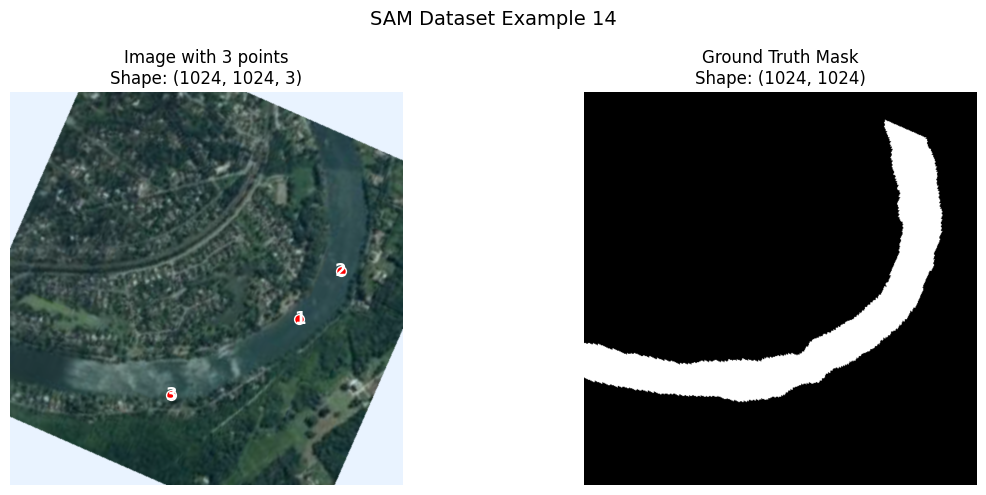

In [16]:
example = train_ds_source[0]
for k,v in example.items():
  print(k,v.shape)

visualize_sam_example(example, image_idx=random.randint(1, 20))



In [17]:
import os
import csv
import matplotlib.pyplot as plt


def plot_metrics(metrics, out_png, out_csv):
    """
    Визуализирует метрики обучения модели
    и сохраняет их в CSV
    """

    epochs = list(range(len(metrics["Train loss"])))

    # ===== SAVE CSV =====
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)

    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "epoch",
            "train_loss",
            "val_loss",
            "precision",
            "recall",
            "iou"
        ])

        for i in epochs:
            writer.writerow([
                i,
                metrics["Train loss"][i],
                metrics["Val loss"][i],
                metrics["Precision"][i],
                metrics["Recall"][i],
                metrics["IoU"][i]
            ])

    # ===== PLOT =====
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    axes[0, 0].plot(epochs, metrics["Train loss"])
    axes[0, 0].set_title("Train Loss")
    axes[0, 0].set_xlabel("Epoch")

    axes[0, 1].plot(epochs, metrics["Val loss"])
    axes[0, 1].set_title("Val Loss")
    axes[0, 1].set_xlabel("Epoch")

    axes[0, 2].plot(epochs, metrics["Precision"])
    axes[0, 2].set_title("Precision")
    axes[0, 2].set_xlabel("Epoch")
    axes[0, 2].set_ylim(0, 1)

    axes[1, 0].plot(epochs, metrics["Recall"])
    axes[1, 0].set_title("Recall")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylim(0, 1)

    axes[1, 1].plot(epochs, metrics["IoU"])
    axes[1, 1].set_title("IoU")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylim(0, 1)

    axes[1, 2].axis("off")

    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()


In [18]:
def segmentation_metrics(preds, targets, threshold=0.5, eps=1e-7):
    """
    preds: (B, H, W) — logits или probabilities
    targets: (B, H, W) — {0,1}
    """

    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    targets = targets.float()

    tp = (preds * targets).sum(dim=(1, 2))
    fp = (preds * (1 - targets)).sum(dim=(1, 2))
    fn = ((1 - preds) * targets).sum(dim=(1, 2))

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    iou = tp / (tp + fp + fn + eps)

    return {
        "precision": precision.mean().item(),
        "recall": recall.mean().item(),
        "iou": iou.mean().item()
    }


In [19]:
def forward_batch(model, batch, device):
    pixel_values = batch["pixel_values"].to(device)
    ground_truth_masks = batch["ground_truth_mask"].float().to(device)

    input_points = batch["input_points"].to(device)
    if input_points.dim() == 3:
        input_points = input_points.unsqueeze(1)

    outputs = model(pixel_values=pixel_values, input_points=input_points, multimask_output=False)

    predicted_masks = outputs.pred_masks

    # ФИКС:
    if predicted_masks.dim() == 5:
        predicted_masks = predicted_masks.squeeze(1)

    predicted_masks = F.interpolate(
        predicted_masks,
        size=(1024, 1024),
        mode="bilinear",
        align_corners=False
    )
    predicted_masks = predicted_masks.squeeze(1)

    return predicted_masks, ground_truth_masks

In [32]:
def train_da_epoch(model, loader_source, loader_target, optimizer, seg_loss_fn, device, epoch, lambda_coral=1.0):
    model.train()

    losses_seg = []
    losses_coral = []

    target_iter = iter(loader_target)

    pbar = tqdm(loader_source, desc=f"Train DA Epoch {epoch}", leave=False)

    for batch_s in pbar:
        # --- Подготовка данных ---
        pixel_values_s = batch_s["pixel_values"].to(device)
        masks_s = batch_s["ground_truth_mask"].float().to(device)
        input_points_s = batch_s["input_points"].to(device)
        if input_points_s.dim() == 3: input_points_s = input_points_s.unsqueeze(1)

        try:
            batch_t = next(target_iter)
        except StopIteration:
            target_iter = iter(loader_target)
            batch_t = next(target_iter)

        pixel_values_t = batch_t["pixel_values"].to(device)
        masks_t = batch_t["ground_truth_mask"].float().to(device)
        input_points_t = batch_t["input_points"].to(device)
        if input_points_t.dim() == 3: input_points_t = input_points_t.unsqueeze(1)

        # --- Forward Pass ---

        # Шаг А: Эмбеддинги
        emb_s = model.get_image_embeddings(pixel_values_s)
        emb_t = model.get_image_embeddings(pixel_values_t)

        # Шаг Б: CORAL Loss
        l_coral = coral_loss(emb_s, emb_t)

        # Шаг В: Сегментация Source
        out_s = model(image_embeddings=emb_s, input_points=input_points_s, multimask_output=False)
        pred_masks_s = out_s.pred_masks

        # ИСПРАВЛЕНИЕ: Если тензор 5D [Batch, Prompts, Masks, H, W], схлопываем Prompts
        if pred_masks_s.dim() == 5:
            pred_masks_s = pred_masks_s.squeeze(1) # [B, 1, 256, 256]

        # Теперь ресайзим 4D тензор
        pred_masks_s = F.interpolate(pred_masks_s, size=(1024, 1024), mode="bilinear", align_corners=False)
        pred_masks_s = pred_masks_s.squeeze(1) # [B, 1024, 1024] для лосса

        l_seg_s = seg_loss_fn(pred_masks_s, masks_s)

        # Шаг Г: Сегментация Target
        out_t = model(image_embeddings=emb_t, input_points=input_points_t, multimask_output=False)
        pred_masks_t = out_t.pred_masks

        # ИСПРАВЛЕНИЕ для Target
        if pred_masks_t.dim() == 5:
            pred_masks_t = pred_masks_t.squeeze(1)

        pred_masks_t = F.interpolate(pred_masks_t, size=(1024, 1024), mode="bilinear", align_corners=False)
        pred_masks_t = pred_masks_t.squeeze(1)

        l_seg_t = seg_loss_fn(pred_masks_t, masks_t)

        # --- Backward ---
        total_loss = l_seg_s + l_seg_t + (lambda_coral * l_coral)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        avg_seg_loss = (l_seg_s.item() + l_seg_t.item()) / 2
        losses_seg.append(avg_seg_loss)
        losses_coral.append(l_coral.item())

        pbar.set_postfix({"SegLoss": f"{avg_seg_loss:.3f}", "CoralLoss": f"{l_coral.item():.3f}"})

    return mean(losses_seg), mean(losses_coral)

In [33]:
@torch.no_grad()
def validate_one_epoch(model, dataloader, loss_fn, device, epoch, threshold=0.5):
    model.eval()

    losses = []
    precisions = []
    recalls = []
    ious = []

    for batch in tqdm(dataloader, desc=f"Val {epoch}", leave=False):
        preds, targets = forward_batch(model, batch, device)

        loss = loss_fn(preds, targets)
        losses.append(loss.item())

        metrics = segmentation_metrics(
            preds,
            targets,
            threshold=threshold
        )

        precisions.append(metrics["precision"])
        recalls.append(metrics["recall"])
        ious.append(metrics["iou"])

    return {
        "loss": mean(losses),
        "precision": mean(precisions),
        "recall": mean(recalls),
        "iou": mean(ious),
    }


In [34]:
# def fit(model, train_dataloader, val_dataloader, optimizer, loss_fn, device, num_epochs, threshold=0.5):

#     metrics = {
#             "Train loss": [],
#             "Val loss": [],
#             "Precision": [],
#             "Recall": [],
#             "IoU": []
#     }

#     bestIoU = 0

#     for epoch in range(num_epochs):
#         train_loss = train_one_epoch(model, train_dataloader, optimizer, loss_fn, device, epoch)
#         val_metrics = validate_one_epoch(model, val_dataloader, loss_fn, device, epoch, threshold=threshold)

#         metrics["Train loss"].append(train_loss)
#         metrics["Val loss"].append(val_metrics["loss"])
#         metrics["Precision"].append(val_metrics["precision"])
#         metrics["Recall"].append(val_metrics["recall"])
#         metrics["IoU"].append(val_metrics["iou"])

#         if bestIoU < val_metrics["iou"]:
#             bestIoU = val_metrics["iou"]
#             torch.save(model.state_dict(), "/content/drive/MyDrive/IT-geo/SEM_1024_paleorusels_vessels_slice.pth")

#         print(
#             f"\nEPOCH {epoch} | "
#             f"Train loss: {train_loss:.4f} | "
#             f"Val loss: {val_metrics['loss']:.4f}\n"
#             f"Precision: {val_metrics['precision']:.4f} | "
#             f"Recall: {val_metrics['recall']:.4f} | "
#             f"IoU: {val_metrics['iou']:.4f}"
#         )

#     return metrics

def fit_da(model, loader_source, loader_target, loader_val, optimizer, seg_loss_fn, device, num_epochs, lambda_coral=1.0, threshold=0.5):

    metrics = {
            "Train Seg Loss": [],
            "Train Coral Loss": [],
            "Val Loss": [],
            "Precision": [],
            "Recall": [],
            "IoU": []
    }

    best_iou = 0.0
    save_path = "/content/drive/MyDrive/IT-geo/SAM_CORAL_best.pth"

    print(f"Starting Domain Adaptation Training for {num_epochs} epochs...")
    print(f"Device: {device} | Lambda CORAL: {lambda_coral}")

    for epoch in range(num_epochs):
        # 1. Train Step
        train_seg_loss, train_coral_loss = train_da_epoch(
            model, loader_source, loader_target, optimizer, seg_loss_fn, device, epoch, lambda_coral
        )

        # 2. Validation Step (используем твою функцию validate_one_epoch)
        val_metrics = validate_one_epoch(
            model, loader_val, seg_loss_fn, device, epoch, threshold=threshold
        )

        # 3. Запись метрик
        metrics["Train Seg Loss"].append(train_seg_loss)
        metrics["Train Coral Loss"].append(train_coral_loss)
        metrics["Val Loss"].append(val_metrics["loss"])
        metrics["Precision"].append(val_metrics["precision"])
        metrics["Recall"].append(val_metrics["recall"])
        metrics["IoU"].append(val_metrics["iou"])

        # 4. Сохранение лучшей модели
        if val_metrics["iou"] > best_iou:
            best_iou = val_metrics["iou"]
            torch.save(model.state_dict(), save_path)
            saved_msg = "-> Model Saved!"
        else:
            saved_msg = ""

        # 5. Вывод
        print(
            f"\nEPOCH {epoch} | "
            f"T.Seg: {train_seg_loss:.4f} | T.Coral: {train_coral_loss:.4f} || "
            f"Val Loss: {val_metrics['loss']:.4f}\n"
            f"Prec: {val_metrics['precision']:.4f} | "
            f"Rec: {val_metrics['recall']:.4f} | "
            f"IoU: {val_metrics['iou']:.4f} {saved_msg}"
        )

    return metrics


In [35]:
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Разморозка:
# Размораживаем Vision Encoder для CORAL
for name, param in model.named_parameters():
    if name.startswith("prompt_encoder"):
        param.requires_grad_(False) # Промпты (точки) геометрически простые, можно не учить
    else:
        # Размораживаем mask_decoder и vision_encoder
        param.requires_grad_(True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Optimizer: теперь learning rate для энкодера лучше сделать поменьше, чем для декодера
# ViT очень капризный, если дать большой LR, он развалится.
optimizer = Adam([
    {'params': model.vision_encoder.parameters(), 'lr': 5e-6}, # Осторожный LR для энкодера
    {'params': model.mask_decoder.parameters(), 'lr': 5e-5},   # Обычный LR для головы
], weight_decay=1e-4)

seg_loss_fn = BCETwitterUOLoss(bce_weight=1.0, iou_weight=1.0) # Твой лосс

loader_source = DataLoader(train_ds_source, batch_size=4, shuffle=True, drop_last=True, num_workers=2)
loader_target = DataLoader(train_ds_target, batch_size=4, shuffle=True, drop_last=True, num_workers=2)
loader_val = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2)


In [ ]:
history = fit_da(
    model=model,
    loader_source=loader_source,
    loader_target=loader_target,
    loader_val=loader_val,
    optimizer=optimizer,
    seg_loss_fn=seg_loss_fn,
    device=device,
    num_epochs=25,
    lambda_coral=10.0, # Вес адаптации. Можно варьировать (1.0 ... 100.0)
    threshold=0.5
)



Starting Domain Adaptation Training for 25 epochs...
Device: cuda | Lambda CORAL: 10.0



EPOCH 0 | T.Seg: 0.5420 | T.Coral: 0.2322 || Val Loss: 0.7081
Prec: 0.7225 | Rec: 0.5842 | IoU: 0.4811 -> Model Saved!



EPOCH 1 | T.Seg: 0.4660 | T.Coral: 0.2310 || Val Loss: 0.6705
Prec: 0.6889 | Rec: 0.6903 | IoU: 0.5093 -> Model Saved!



EPOCH 2 | T.Seg: 0.4344 | T.Coral: 0.2301 || Val Loss: 0.5944
Prec: 0.7317 | Rec: 0.6981 | IoU: 0.5606 -> Model Saved!



EPOCH 3 | T.Seg: 0.4168 | T.Coral: 0.2376 || Val Loss: 0.6031
Prec: 0.7449 | Rec: 0.7194 | IoU: 0.5804 -> Model Saved!



EPOCH 4 | T.Seg: 0.4132 | T.Coral: 0.2286 || Val Loss: 0.8613
Prec: 0.7287 | Rec: 0.4757 | IoU: 0.4025 



EPOCH 5 | T.Seg: 0.4121 | T.Coral: 0.2332 || Val Loss: 0.6283
Prec: 0.7146 | Rec: 0.7188 | IoU: 0.5601 



EPOCH 6 | T.Seg: 0.4046 | T.Coral: 0.2341 || Val Loss: 0.6569
Prec: 0.7377 | Rec: 0.6797 | IoU: 0.5360 



EPOCH 7 | T.Seg: 0.3962 | T.Coral: 0.2369 || Val Loss: 0.6443
Prec: 0.7026 | Rec: 0.6705 | IoU: 0.5483 



EPOCH 8 | T.Seg: 0.4008 | T.Coral: 0.2346 || Val Loss: 0.7900
Prec: 0.8205 | Rec: 0.4947 | IoU: 0.4296 



EPOCH 9 | T.Seg: 0.3931 | T.Coral: 0.2302 || Val Loss: 0.6091
Prec: 0.8028 | Rec: 0.6570 | IoU: 0.5669 



EPOCH 10 | T.Seg: 0.3810 | T.Coral: 0.2358 || Val Loss: 0.5530
Prec: 0.8102 | Rec: 0.7033 | IoU: 0.6091 -> Model Saved!


Train DA Epoch 11:  29%|██▉       | 40/138 [02:16<05:21,  3.28s/it, SegLoss=0.433, CoralLoss=0.258]

In [ ]:
plot_metrics(
    history,
    out_png="/content/drive/MyDrive/IT-geo/SEM_1024_paleorusels_vessels_slice.png",
    out_csv="/content/drive/MyDrive/IT-geo/SEM_1024_paleorusels_vessels_slice.csv"
)
